In [1]:
!pip install rdkit-pypi


import itertools

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity


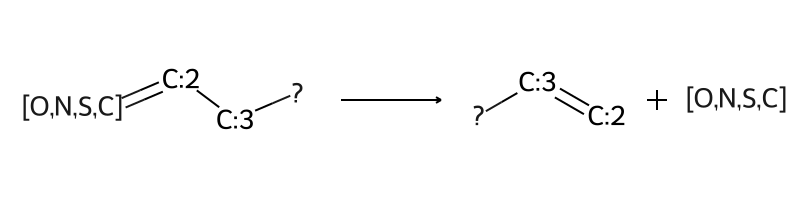

In [2]:
# Define the reaction SMARTS
reaction_smarts = '[O,N,S,C:1]=[C:2]-[C:3]-[O+,N+,S+:4]>>[C:2]=[C:3]-[O+,N+,S+:1].[O,N,S,C:4]'

# Create a reaction object
reaction = AllChem.ReactionFromSmarts(reaction_smarts)

# Draw the reaction
reaction_image = Draw.ReactionToImage(reaction)

# Display the image
display(reaction_image)

# Calculating edges and nodes using SMARTS 

Initial molecule mass: 179.058243148

Peaks generated after iterative fragmentation:
            mz  intensity
0  180.065520       10.0
1  162.054955       10.0
2  135.068414       10.0
3  133.051667       10.0
4  105.033491       10.0

Fragmentation Tree:
Parent Mass: 180.07 -> Child Mass: 162.05 via simple_inductive_cleavage
Parent Mass: 180.07 -> Child Mass: 135.07 via remote_hydrogen_rearrangement_b
Parent Mass: 162.05 -> Child Mass: 133.05 via inductive_cleavage_heteroatom
Parent Mass: 133.05 -> Child Mass: 105.03 via simple_inductive_cleavage

Generated Fragments:
Fragment with Mass: 180.07


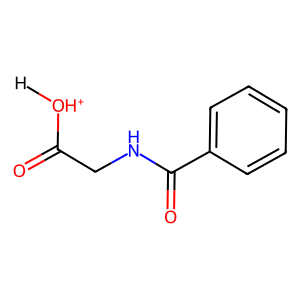

Fragment with Mass: 162.05


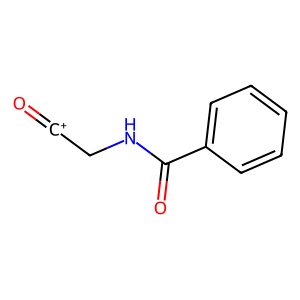

Fragment with Mass: 135.07


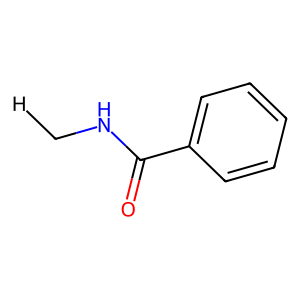

Fragment with Mass: 133.05


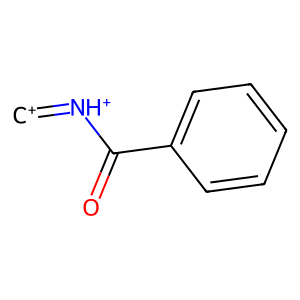

Fragment with Mass: 105.03


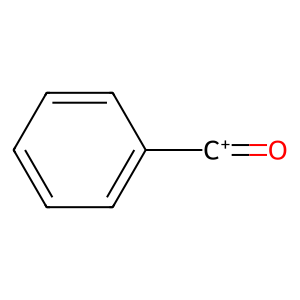

In [3]:
# Step 1: Define initial data and molecule
cinnamic_acid_smiles = 'OC(=O)CNC(=O)C1=CC=C(C=C1)'
cinnamic_acid = Chem.MolFromSmiles(cinnamic_acid_smiles)

# Calculate initial molecule mass
initial_mass = CalcExactMolWt(cinnamic_acid)
print("Initial molecule mass:", initial_mass)

# Define reaction for water loss
fragmentations = {
    # Positive ion mode 
    'simple_inductive_cleavage': '[O+,N+,S+:2]-[C:1]>>[C+:1].[O,N,S:2]',  # Simple inductive cleavage with charge migration
    
    'inductive_cleavage_heteroatom': '[O,N,S:1]-[C:2]-[*+:3]>>[O+,N+,S+:1]=[C+:2].[*:3]',  # Heteroatom-assisted cleavage
    
    'displacement_reaction_positive_a': '[O,N,S:1]-[C:2]-[C:3]-[*+:4]>>[C:3]1-[C:2]-[O+,N+,S+:1]-1.[*:4]',  # Displacement reaction in positive ion mode
    
    'displacement_reaction_positive_b': '[O,N,S,C:1]=[C:2]-[C:3]-[*+:4]>>[C:2]=[C:3]-[O+,N+,S+:1].[*:4]',  # Displacement reaction in positive ion mode

    'beta_hydrogen_removal_positive': '[O,N,S:1]-[C:2]-[C;H:3]-[C:4]-[*+:5]>>[O+,N+,S+;H1:1]-[C:2]-[C:3]=[C:4].[*:5]',  # β-hydrogen removal with charge migration
    
    'grob_wharton_fragmentation': '[O,N,S:1]-[C:2]-[C:3]-[C:4]-[*+:5]>>[O+,N+,S+:1]=[C:2].[C:3]=[C:4].[*:5]',  # Grob-Wharton fragmentation

    # Negative ion mode 
    'alpha_elimination': '[C:1]-[C:2](=[O,S,N:3])-[O-,N-,S-:4]>>[C-:1].[C:2](=[O,S,N:3])-[O,N,S:4]',  # α-Elimination
    
    'gamma_elimination': '[O-,N-,S-:1]-[C:2]=[C:3]-[C:4]-[*:5]>>[O,N,S:1]=[C:2]-[C:3]=[C:4].[*-:5]',  # γ-Elimination
    
    'epsilon_elimination': '[O-,N-,S-:1]-[C:2]=[C:3]-[C:4]=[C:5]-[C:6][*:7]>>[O,N,S:1]=[C:2]-[C:3]=[C:4]-[C:5]=[C:6].[*-:7]',  # ε-Elimination
    
    'displacement_reaction_negative': '[O-,N-,S-:1]-[C:2]-[C:3]-[*:4]>>[O,N,S:1]1-[C:2]-[C:3]-1.[*-:4]',  # Displacement reaction (negative mode)
    
    'beta_hydrogen_removal_negative': '[O-,N-,S-:1]-[C:2]-[C;H:3]-[C:4]-[*:5]>>[O,N,S;H1:1]-[C:2]-[C:3]=[C:4].[*-:5]',  # β-Hydrogen removal (negative mode)

    #CRF_reactions 
    'remote_hydrogen_rearrangement_a': '[O,N,S:1]-[C:2]-[C:3]-[H:4]>>[C:2]=[C:3].[H:4]-[O,N,S:1]',  # Remote H rearrangement
       
    'remote_hydrogen_rearrangement_b': '[C:1]-[C:2]-[O:3]-[H:4]>>[C:1]-[H:4].[C:2]=[O:3]',  # Alternative remote H rearrangement
    
    'retro_diels_alder': '[C:1]1=[C:2]-[C:3]-[C:4]-[C:5]-[C:6]-1>>[C:6]=[C:1]-[C:2]=[C:3].[C:4]=[C:5]',  # Retro-Diels-Alder (RDA) reaction
    
    'retro_ene': '[C:2]=[C:1]-[C:3]-[C:4]-[C:5]-[H:6]>>[H:6]-[C:2]-[C:3]=[C:1].[C:4]=[C:5]',  # Retro-ene reaction
    
    'retro_heteroene': '[O,N,S:1]=[C:2]-[C:3]-[C:4]-[C:5]-[H:6]>>[H:6]-[O,N,S:1]-[C:2]=[C:3].[C:4]=[C:5]',  # Retro-heteroene reaction

    'charge_remote_fragmentation': '[H:1]-[C:2]-[C:3]-[C:4]-[C:5]-[H:6]>>[C:2]=[C:3].[C:4]=[C:5].[H:1]-[H:6]',  # Charge remote fragmentation

    'aromatic_elimination': '[C:1]-[C:2]-[C:3]-[C:4]-[C:5]-[C:6]-[C:7]-[C:8]-[O,N,S:9]>>[C:1]=[C:8]-[O,N,S:9].[c:2]1[c:3][c:4][c:5][c:6][c:7]1',  
   
    'pericyclic_shift': '[C:1]-[C:2]-[C:3]-[C:4]-[C:5]-[C:6]>>[C:1]=[C:2].[C:5]=[C:6].[C:3]=[C:4]', 
    
    'pericyclic_1_3_shift': '[H:1]-[C:2]-[C:3]=[C:4]-[C:5]=[C:6]>>[C:2]=[C:3]-[C:4](-[H:1])=[C:5]-[C:6]', 
    
    'pericyclic_1_5_shift': '[H:1]-[C:2]-[C:3]=[C:4]-[C:5]=[C:6]>>[C:2]=[C:3]-[C:4]=[C:5]-[C:6](-[H:1])', 
    
    'carbon_monoxide_elimination_a': '[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-[C:6](=O)-1>>[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-1.[C:6](#O)',  # CO elimination from cyclic carbonyls
    
    'carbon_monoxide_elimination_b': '[C:6](#[O+1])-[C:1]-[C:2]-[C:3]-[C:4]-[C-:5]>>[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-1.[C:6](#O)',  # Alternative CO elimination
    
#    'radical_fragmentation': '[C:1]-[O,N,S:2]>>[C^1:1].[O^1,N^1,S^1:2]',  # Radical fragmentation
}

# Convert SMARTS to reaction objects
reactions = {name: AllChem.ReactionFromSmarts(smarts) for name, smarts in fragmentations.items()}

# Step 3: Apply ionisation
ionisation_rxn = AllChem.ReactionFromSmarts('[O,N,S:2][C:1]>>[H][O+,N+,S+:2][C:1]')
product_sets = ionisation_rxn.RunReactants((cinnamic_acid,))

if not product_sets:
    raise ValueError("Ionisation failed, no products generated.")
ionised_product = product_sets[0][0]
Chem.SanitizeMol(ionised_product)
ionised_mass = CalcExactMolWt(ionised_product)
peaks_df = pd.DataFrame({'mz': [ionised_mass], 'intensity': [10.0]})

# Step 4: Apply fragmentation and visualize fragments
fragmentation_tree = []
iteration = 0
new_fragments = [ionised_product]
processed_fragments = set()
fragment_images = []

while new_fragments:
    iteration += 1
    current_fragments = new_fragments
    new_fragments = []

    for fragment in current_fragments:
        fragment_key = Chem.MolToInchiKey(fragment)
        if fragment_key in processed_fragments:
            continue  # Skip already processed fragments
        processed_fragments.add(fragment_key)

        fragment_mass = CalcExactMolWt(fragment)

        # Visualize and store the fragment image
        fragment_images.append((fragment_mass, Draw.MolToImage(fragment)))

        for loss_name, reaction in reactions.items():
            try:
                product_sets = reaction.RunReactants((fragment,))
                if product_sets:
                    for product in product_sets:
                        new_fragment = product[0]
                        try:
                            Chem.SanitizeMol(new_fragment)
                        except Exception:
                            continue  # Skip invalid fragments

                        new_fragment_mass = CalcExactMolWt(new_fragment)
                        if not any(abs(new_fragment_mass - mz) < 0.01 for mz in peaks_df['mz']):
                            peaks_df = pd.concat(
                                [peaks_df, pd.DataFrame({'mz': [new_fragment_mass], 'intensity': [10.0]})],
                                ignore_index=True,
                            )
                            new_fragments.append(new_fragment)
                            fragmentation_tree.append((fragment_mass, new_fragment_mass, loss_name))

            except Exception:
                continue  # Skip errors during reaction application

# Display final peaks_df
print("\nPeaks generated after iterative fragmentation:\n", peaks_df)

# Display the fragmentation tree
print("\nFragmentation Tree:")
for parent_mass, child_mass, reaction in fragmentation_tree:
    print(f"Parent Mass: {parent_mass:.2f} -> Child Mass: {child_mass:.2f} via {reaction}")

# Display fragment images
print("\nGenerated Fragments:")
for mass, img in fragment_images:
    print(f"Fragment with Mass: {mass:.2f}")
    display(img)

# Plotting the computed fragmentation tree

Edge added: Parent m/z 180.07 -> Child m/z 162.05 via simple_inductive_cleavage
Edge added: Parent m/z 180.07 -> Child m/z 135.07 via remote_hydrogen_rearrangement_b
Edge added: Parent m/z 162.05 -> Child m/z 133.05 via inductive_cleavage_heteroatom
Edge added: Parent m/z 133.05 -> Child m/z 105.03 via simple_inductive_cleavage
Node depths from precursor node: {0: 0, 1: 1, 2: 1, 3: 2, 4: 3}
Nodes grouped by levels: defaultdict(<class 'list'>, {0: [0], 1: [1, 2], 2: [3], 3: [4]})
Node positions (updated for better layout): {0: (-1.0, 0.0), 1: (-2.0, -1.5), 2: (0.0, -1.5), 3: (-1.0, -3.0), 4: (-1.0, -4.5)}


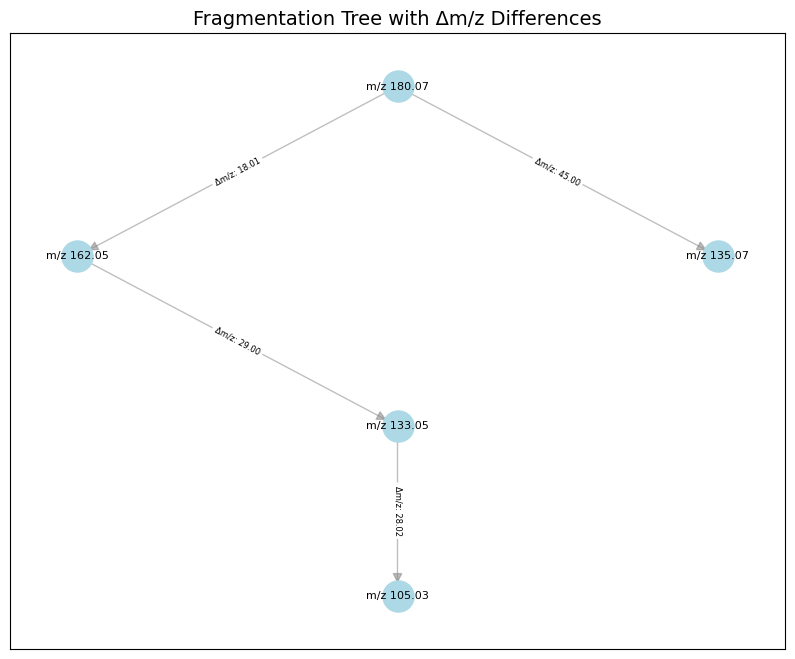

In [4]:

G = nx.DiGraph()

# Add nodes and edges based on the fragmentation_tree
for parent_mass, child_mass, reaction in fragmentation_tree:
    # Find indices of parent and child nodes based on their m/z values
    parent_node = peaks_df[peaks_df['mz'].apply(lambda x: abs(x - parent_mass) < 0.01)].index[0]
    child_node = peaks_df[peaks_df['mz'].apply(lambda x: abs(x - child_mass) < 0.01)].index[0]

    # Add nodes and edge from parent to child
    if parent_node not in G:
        G.add_node(parent_node, label=f"m/z {parent_mass:.2f}")
    if child_node not in G:
        G.add_node(child_node, label=f"m/z {child_mass:.2f}")
    G.add_edge(parent_node, child_node, label=reaction)
    print(f"Edge added: Parent m/z {parent_mass:.2f} -> Child m/z {child_mass:.2f} via {reaction}")

# Identify the precursor node (largest m/z value)
precursor_node = peaks_df['mz'].idxmax()  # Node with the largest m/z
if precursor_node not in G.nodes:
    raise ValueError("Precursor node is not in the graph.")

# Calculate node levels (distance from the precursor node)
node_depths = nx.single_source_shortest_path_length(G, precursor_node)
print("Node depths from precursor node:", node_depths)

# Group nodes by their depth (level in the tree)
levels = defaultdict(list)
for node, depth in node_depths.items():
    levels[depth].append(node)
print("Nodes grouped by levels:", levels)

# Custom layout with clustered positions for duplicate fragments
pos = {}
horizontal_spacing = 2.0  # Spacing between unique groups at the same level
vertical_spacing = 1.5    # Spacing between levels

for depth, nodes in levels.items():
    # Group nodes by their m/z values to detect duplicates
    mz_groups = defaultdict(list)
    for node in nodes:
        mz = peaks_df.loc[node, 'mz']
        mz_groups[mz].append(node)

    # Assign positions within each group
    offset = -len(mz_groups) * horizontal_spacing / 2  # Center groups horizontally
    for mz, group_nodes in mz_groups.items():
        group_size = len(group_nodes)
        for i, node in enumerate(group_nodes):
            pos[node] = (
                offset + i * (horizontal_spacing / group_size),  # Cluster nodes within the group
                -depth * vertical_spacing
            )
        offset += horizontal_spacing  # Move to the next group

print("Node positions (updated for better layout):", pos)

# Add m/z differences and transition probabilities as edge labels
for edge in G.edges():
    parent, child = edge
    mz_diff = abs(peaks_df.loc[parent, 'mz'] - peaks_df.loc[child, 'mz'])
    parent_intensity = peaks_df.loc[parent, 'intensity']
    child_intensity = peaks_df.loc[child, 'intensity']
    transition_prob = (
        parent_intensity / child_intensity if child_intensity != 0 else 0
    )
    # Format the label with Δm/z and transition probability
    G.edges[parent, child]['label'] = f"Δm/z: {mz_diff:.2f}"

# Draw the updated graph
plt.figure(figsize=(10, 8))

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# Draw the edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray', alpha=0.5)

# Draw the node labels (m/z values)
node_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# Draw the edge labels (m/z differences and transition probabilities)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# Set plot title
plt.title("Fragmentation Tree with Δm/z Differences", fontsize=14)

# Show the plot
plt.show()

# Cosine Similarity

In [5]:
# Function to normalize spectrum to max intensity of 1
def normalize_spectrum(spectrum):
    if spectrum['intensity'].max() == 0:
        raise ValueError("Spectrum has zero maximum intensity; normalization is not possible.")
    spectrum = spectrum.copy()
    max_intensity = spectrum['intensity'].max()
    spectrum['intensity'] = spectrum['intensity'] / max_intensity
    return spectrum

# Function to calculate intensities for each fragment node based on the tree and transition probabilities
def calculate_intensities_from_tree(tree_edges, precursor_intensity, transition_probs):
    intensities = {}  # Initialize an empty dictionary to store intensities
    for (u, v) in tree_edges:
        if u not in intensities:
            # Set the precursor's intensity if it's not already in the dictionary
            intensities[u] = precursor_intensity
        if (u, v) in transition_probs:
            # Calculate the intensity of the child node using the parent's intensity and the transition probability
            intensities[v] = intensities[u] * transition_probs[(u, v)]
    return intensities

# Function to back-calculate the spectrum from the tree and transition probabilities
def back_calculate_spectrum_from_tree(tree_nodes, tree_edges, peaks_df, transition_probs):
    precursor_intensity = peaks_df.loc[tree_nodes[0], 'intensity']  # Use the first node as the precursor
    calculated_intensities = calculate_intensities_from_tree(tree_edges, precursor_intensity, transition_probs)
    
    # Map the calculated intensities back to the peaks dataframe
    back_calculated_spectrum = peaks_df.loc[tree_nodes][['mz']].copy()
    back_calculated_spectrum['intensity'] = back_calculated_spectrum.index.map(calculated_intensities).fillna(0)
    
    # Normalize the back-calculated spectrum
    back_calculated_spectrum = normalize_spectrum(back_calculated_spectrum)
    
    return back_calculated_spectrum

# Align the m/z values of the original and back-calculated spectra
def align_spectra(original_spectrum, calculated_spectrum):
    # Merge the spectra based on the m/z column, filling missing intensities with 0
    merged_spectrum = pd.merge(original_spectrum, calculated_spectrum, on='mz', how='outer', suffixes=('_orig', '_calc')).fillna(0)
    return merged_spectrum

# Calculate cosine similarity between original and back-calculated spectra
def calculate_cosine_similarity(merged_spectrum):
    # Ensure the intensities are aligned and calculate cosine similarity
    original_intensities = merged_spectrum['intensity_orig'].values.reshape(1, -1)
    calculated_intensities = merged_spectrum['intensity_calc'].values.reshape(1, -1)
    similarity = cosine_similarity(original_intensities, calculated_intensities)[0, 0]
    return similarity

# Extract unique nodes from edges
def calculate_nodes_from_edges(edges):
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    return sorted(nodes)  # Return nodes in sorted order for consistency

# Example usage to calculate cosine similarity
selected_nodes = calculate_nodes_from_edges(edges)  # Nodes selected by ILP in the fragmentation tree
original_spectrum = peaks_df[['mz', 'intensity']].copy()
original_spectrum = normalize_spectrum(original_spectrum)
print("\nOriginal spectrum (normalized):\n", original_spectrum)

# Generate the back-calculated spectrum
back_calculated_spectrum = back_calculate_spectrum_from_tree(selected_nodes, edges, peaks_df, transition_probabilities)
print("\nBack-calculated spectrum (normalized):\n", back_calculated_spectrum)

# Align the original and back-calculated spectra
merged_spectrum = align_spectra(original_spectrum, back_calculated_spectrum)

# Calculate cosine similarity between the two spectra
cosine_sim = calculate_cosine_similarity(merged_spectrum)

print(f"Cosine Similarity between original and back-calculated spectra (normalized): {cosine_sim:.4f}")


NameError: name 'edges' is not defined